In [1]:
import numpy as np
import os, sys, re

import astropy
from astropy.io import fits
from astropy.io.votable import writeto as writetoVO
from astropy.table import Table, Column
from astropy.io.votable import parse_single_table

# optparse is being deprecated and argparse is now available on Zeus.
from argparse import ArgumentParser
from turtle import color
import matplotlib.pyplot as plt
from matplotlib import markers
from matplotlib.pyplot import axes
import matplotlib
import pandas as pd
import glob
import numpy as np
import astropy
import matplotlib.pyplot as plt
import pandas as pd
import camb
import astroquery
import healpy
import astropy.units as u
import sympy
import treecorr
import Corrfunc
import math
from astropy.io import fits
from astropy.wcs import WCS
# %matplotlib inline
import healpy as hp
import scipy

plt.rcParams['savefig.facecolor'] = "1"

In [39]:
obsid_breakdown=pd.read_csv('./Obsid_key.csv',index_col=0)
obsid_breakdown.loc['2018-01-26','First Obsid'].dtype

dtype('int64')

### Preamble: getting a subset of ns sources we would expect to be bright, compact.

In [3]:
ns_cat=fits.open('/home/brandon/PHD/Data/ionosphere/NVSS_SUMSS_psfcal.fits')
ns_cat_DF=pd.DataFrame(ns_cat[1].data)
ns_skycoord=astropy.coordinates.SkyCoord(ns_cat_DF.RAJ2000,ns_cat_DF.DEJ2000,frame='fk5',unit=u.deg)

In [4]:
# mega_dataframe=pd.concat(Dataframes_raw,ignore_index=True)
# mega_dataframe.reset_index(inplace=True,drop=True)
# mega_dataframe.dropna(axis=0,how='any',subset=['ra','dec'],inplace=True)
# mega_skycoord=astropy.coordinates.SkyCoord(mega_dataframe.ra,mega_dataframe.dec,frame='fk5',unit=u.deg)

In [5]:
# idx1,idx2,sep2d,dist3d=astropy.coordinates.search_around_sky(ns_skycoord,mega_skycoord,1*u.arcmin)

In [6]:
# ns_cat_DF_mod=ns_cat_DF.copy(deep=True)
# ns_cat_DF_mod['local_RMS_GLEAM_X']=np.nan
# for i in range(len(idx1)):
#     idx1_index=idx1[i]
#     ns_cat_DF_mod.iloc[idx1_index,-1]=np.nanmean(mega_dataframe.iloc[idx2[idx1==idx1_index],:].local_rms)

In [7]:
# ns_cat_DF_mod_good_subset=ns_cat_DF_mod[ns_cat_DF_mod['peak_flux']/ns_cat_DF_mod['local_RMS_GLEAM_X']>5]

In [8]:
# ns_cat_DF_mod_good_subset.to_csv('/home/brandon/PHD/Data/ionosphere/ns_cat_DF_mod_good_subset.csv',index=False)
ns_cat_DF_mod_good_subset=pd.read_csv('/home/brandon/PHD/Data/ionosphere/ns_cat_DF_mod_good_subset.csv')
ns_cat_DF_mod_good_subset.dropna(axis=0,how='any',subset=['RAJ2000','DEJ2000'],inplace=True)
# ns_cat_DF_mod_good_subset=ns_cat_DF

### Single night analysis with the NVSS derived groups

In [9]:
night='2020_10_25'

In [10]:
test_data_fits=0
test_data_fits_2=13
direc_single_night='/home/brandon/PHD/Data/ionosphere/'+night+'/'
inputs_single_night=glob.glob(direc_single_night+'*rescaled_comp.fits')
# for i in range(len(inputs)):
#     locals()['fits_file_'+str(inputs[i][45:55])]=fits.open('/home/brandon/PHD/Data/ionosphere/2020_10_01/'+inputs[i][45:55]+'_deep-MFS-image-pb_warp_rescaled_comp.fits')
#     locals()['DF_'+str(inputs[i][45:55])]=pd.DataFrame(locals()['fits_file_'+str(inputs[i][45:55])][1].data)
#     locals()['DF_'+str(inputs[i][45:55])].add_prefix(str(inputs[i][45:55])+'_')
Field_numbers_single_night=dict()
Fits_files_single_night=dict()
Dataframes_single_night=dict()
Skycoords_single_night=dict()
for i in range(0,len(inputs_single_night)):
    Field_numbers_single_night[i]=inputs_single_night[i][45:55]
    Fits_files_single_night[i]=fits.open('/home/brandon/PHD/Data/ionosphere/'+night+'/'+inputs_single_night[i][45:55]+'_deep-MFS-image-pb_warp_rescaled_comp.fits')
    Dataframes_single_night[i]=pd.DataFrame(Fits_files_single_night[i][1].data)
    Dataframes_single_night[i].dropna(axis=0,how='any',subset=['ra','dec'],inplace=True)    
    Skycoords_single_night[i]=astropy.coordinates.SkyCoord(Dataframes_single_night[i].ra,Dataframes_single_night[i].dec,frame='fk5',unit=u.deg)
    # Dataframes_single_night[i]=Dataframes_single_night[i].add_suffix('_'+inputs_single_night[i][45:55])
    # Dataframes_single_night[i][Field_numbers_single_night[i]+'_source_row_no']=np.arange(0,len(Dataframes_single_night[i]))

    Dataframes_single_night[i].reset_index(drop=True,inplace=True)
# ns_cat=fits.open('/home/brandon/PHD/Data/ionosphere/NVSS_SUMSS_psfcal.fits')
# ns_cat_DF=pd.DataFrame(ns_cat[1].data)

In [29]:
Field_numbers_single_night

{0: '1287680816',
 1: '1287684416',
 2: '1287679616',
 3: '1287664616',
 4: '1287682016',
 5: '1287675416',
 6: '1287683216',
 7: '1287668216',
 8: '1287677816',
 9: '1287662216',
 10: '1287691616',
 11: '1287663416',
 12: '1287661016',
 13: '1287669416',
 14: '1287690416',
 15: '1287692816',
 16: '1287685616',
 17: '1287689216',
 18: '1287686816',
 19: '1287667016',
 20: '1287676616',
 21: '1287665816',
 22: '1287688016'}

In [11]:
fields_to_use=len(inputs_single_night)

In [12]:
#Pre-match: cutting down the dataframes to only the subsample of ns sources.
ns_cat_DF_mod_good_subset_skycoord=astropy.coordinates.SkyCoord(ns_cat_DF_mod_good_subset.RAJ2000,ns_cat_DF_mod_good_subset.DEJ2000,frame='fk5',unit=u.deg)
for i in range(fields_to_use):
    idx1,idx2,sep2d,dist3d=astropy.coordinates.search_around_sky(ns_cat_DF_mod_good_subset_skycoord,Skycoords_single_night[i],1*u.arcmin)
    if len(idx1)>0:
        Dataframes_single_night[i]=Dataframes_single_night[i].iloc[idx2,:]
        Dataframes_single_night[i].reset_index(drop=True,inplace=True)
        Skycoords_single_night[i]=astropy.coordinates.SkyCoord(Dataframes_single_night[i].ra,Dataframes_single_night[i].dec,frame='fk5',unit=u.deg)
        # Dataframes_single_night[i]=Dataframes_single_night[i].add_suffix('_'+inputs_single_night[i][45:55])
        Dataframes_single_night[i]['Source_row_no']=np.arange(0,len(Dataframes_single_night[i]))
        Dataframes_single_night[i]['obs_id']=Field_numbers_single_night[i]
        Dataframes_single_night[i]['sep_NVSS_GLEAM-X']=sep2d.arcmin

In [13]:
mega_dataframe_single_night=pd.concat(Dataframes_single_night,ignore_index=True)
mega_dataframe_single_night.reset_index(inplace=True,drop=True)
mega_dataframe_single_night.dropna(axis=0,how='any',subset=['ra','dec'],inplace=True)
mega_dataframe_single_night['blur']=np.log10(mega_dataframe_single_night['int_flux']/mega_dataframe_single_night['peak_flux'])
mega_dataframe_single_night['night']=night
mega_skycoord_single_night=astropy.coordinates.SkyCoord(mega_dataframe_single_night.ra,mega_dataframe_single_night.dec,frame='fk5',unit=u.deg)

In [14]:
mega_dataframe_single_night.columns

Index(['island', 'source', 'background', 'local_rms', 'ra_str', 'dec_str',
       'ra', 'err_ra', 'dec', 'err_dec', 'peak_flux', 'err_peak_flux',
       'int_flux', 'err_int_flux', 'a', 'err_a', 'b', 'err_b', 'pa', 'err_pa',
       'flags', 'residual_mean', 'residual_std', 'uuid', 'psf_a', 'psf_b',
       'psf_pa', 'Source_row_no', 'obs_id', 'sep_NVSS_GLEAM-X', 'blur',
       'night'],
      dtype='object')

In [15]:
idx1,idx2,sep2d,dist3d=astropy.coordinates.search_around_sky(ns_cat_DF_mod_good_subset_skycoord,mega_skycoord_single_night,0.5*u.arcmin)

In [16]:
#need to group by idx1.
source_compilation_ns_base=dict()
source_compilation_ns_base_compact=dict()
unique_idx1=np.unique(idx1)
# night_info_dict={'min_obsid':np.nan,'max_obsid':np.nan,'amount_of_sources':np.nan,'mean_blur':}
for i in range(len(unique_idx1)):
    idx1_index=unique_idx1[i]
    array_index=idx2[idx1==idx1_index]
    source_info=mega_dataframe_single_night.iloc[array_index,:]
    source_info['mean_flux_source']=np.nanmean(source_info['int_flux'])
    source_info['norm_diff_frac']=source_info['int_flux']/source_info['mean_flux_source']
    source_info['log_norm_diff_frac']=np.log10(source_info['int_flux']/source_info['mean_flux_source'])
    source_info['log_error_diff_frac']=np.log10(source_info['err_int_flux']/source_info['mean_flux_source'])
    source_info['error_diff_frac']=source_info['err_int_flux']/source_info['mean_flux_source']
    source_info['std_dev_flux']=np.nanstd(source_info['int_flux'])/source_info['mean_flux_source']
    source_info['mean_blur_source']=np.nanmean(source_info['blur'])
    source_info['mean_diff']=np.nanmean(source_info['sep_NVSS_GLEAM-X'])
    source_info['source']=i
    source_info['data_points']=len(array_index)
    source_info['obs_id_int']=source_info['obs_id'].to_numpy(dtype='int64')
    source_info['pa']=astropy.coordinates.position_angle(ns_cat_DF_mod_good_subset_skycoord[idx1_index].ra,
                                                        ns_cat_DF_mod_good_subset_skycoord[idx1_index].dec,
                                                        mega_skycoord_single_night[array_index].ra,
                                                        mega_skycoord_single_night[array_index].ra).deg
    source_info['mean_diff_weight']=np.sum((source_info['int_flux']/source_info['err_int_flux'])*np.absolute(source_info['int_flux']-source_info['mean_flux_source']))
    source_info.sort_values(by='obs_id',inplace=True,ascending=True)
    source_info.reset_index(drop=True,inplace=True)
    source_info_compact=source_info
    # source_info_compact=source_info[['obs_id','ra','dec','local_rms','int_flux','peak_flux','sep_NVSS_GLEAM-X', 'blur','mean_flux_source', 'norm_diff_frac','error_diff_frac', 'std_dev_flux','mean_blur_source','mean_diff','night','source','data_points','pa']]
    source_compilation_ns_base[i]=source_info
    source_compilation_ns_base_compact[i]=source_info_compact


/tmp/ipykernel_7521/3057640703.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_info['mean_flux_source']=np.nanmean(source_info['int_flux'])
/tmp/ipykernel_7521/3057640703.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_info['norm_diff_frac']=source_info['int_flux']/source_info['mean_flux_source']
/tmp/ipykernel_7521/3057640703.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [17]:
mega_dataframe_source_based=pd.concat(source_compilation_ns_base_compact,ignore_index=True)
mega_dataframe_source_based.sort_values(by=['mean_diff_weight','obs_id_int'],inplace=True,ascending=[False,True])
mega_dataframe_source_based.reset_index(drop=True,inplace=True)

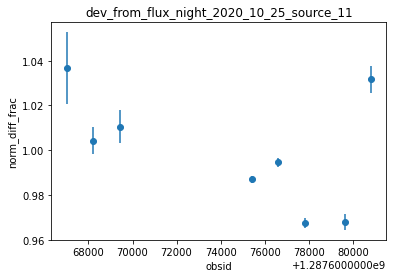

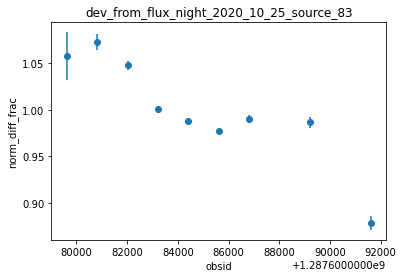

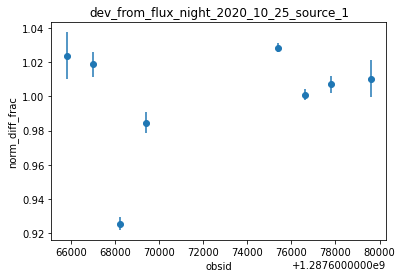

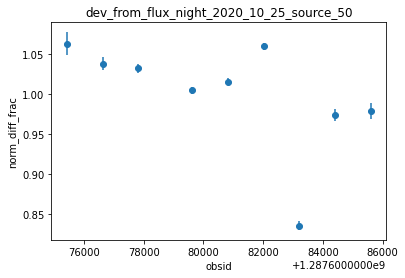

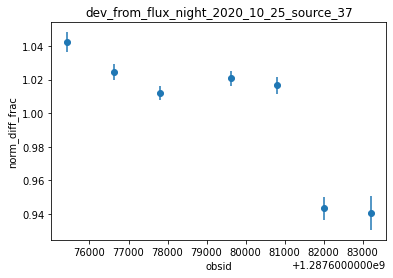

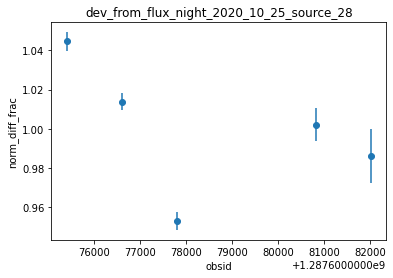

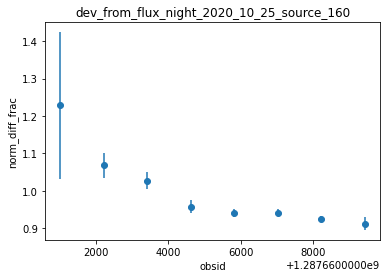

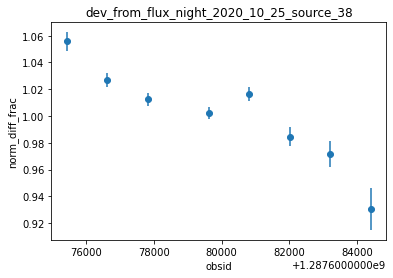

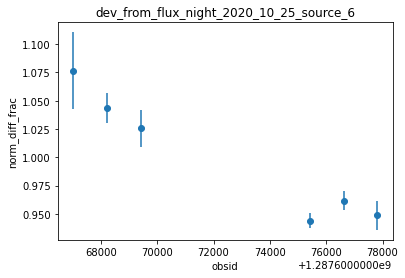

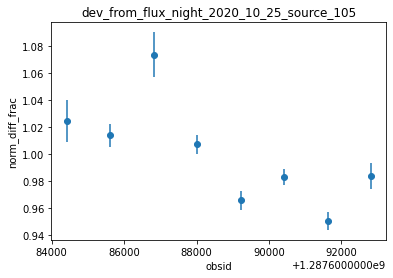

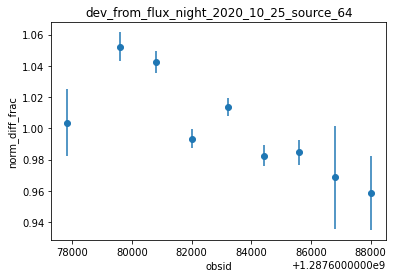

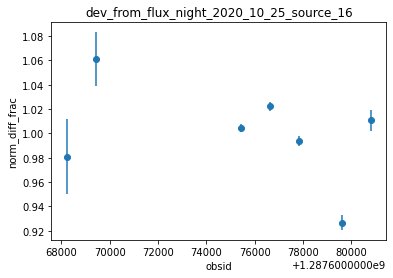

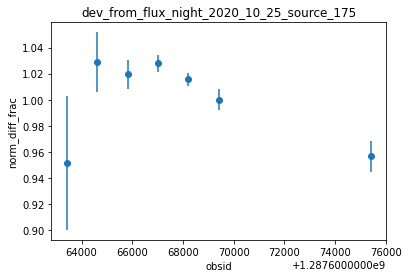

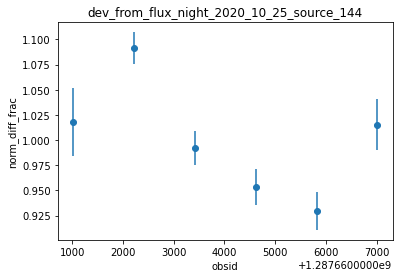

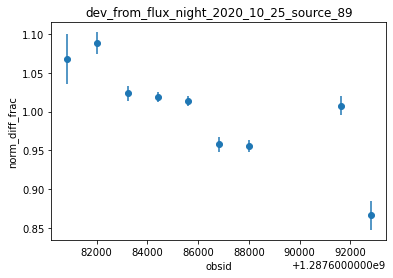

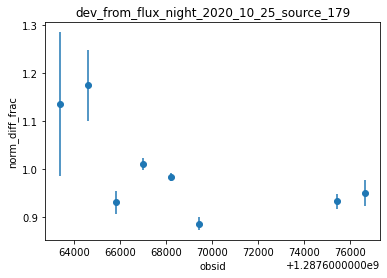

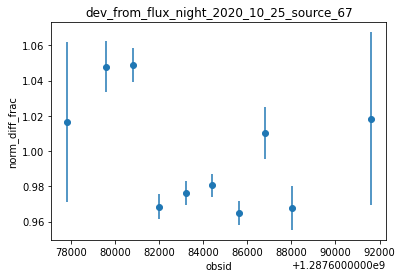

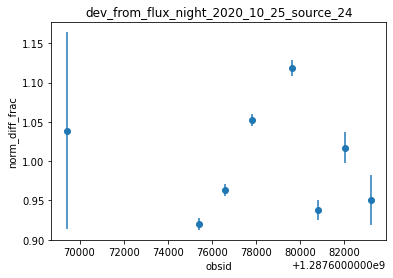

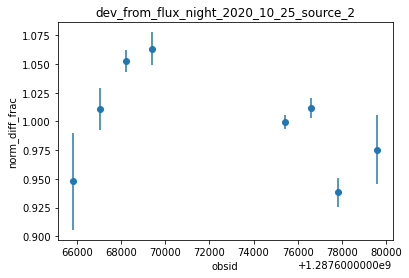

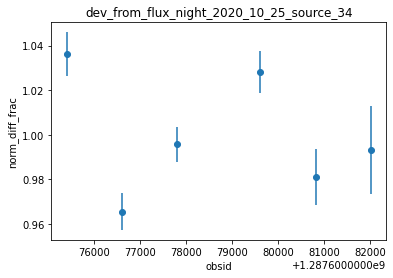

In [18]:
amount_of_plots=20
sources=pd.unique(mega_dataframe_source_based['source'])
for i in range(amount_of_plots):
    source_index=sources[i]
    mask=mega_dataframe_source_based['source']==source_index
    masked_dataframe=mega_dataframe_source_based[mask]
    masked_dataframe.reset_index(drop=True,inplace=True)
    plt.errorbar(masked_dataframe['obs_id_int'],
        masked_dataframe['norm_diff_frac'],
        yerr=masked_dataframe['error_diff_frac'],
        fmt='o')
    plt.xlabel('obsid')
    plt.ylabel('norm_diff_frac')
    titlen=('dev_from_flux_night_'
        +str(masked_dataframe.loc[0,'night'])
        +'_source_'+str(masked_dataframe.loc[0,'source']))
    plt.title(titlen)
    plt.show()
    plt.close()

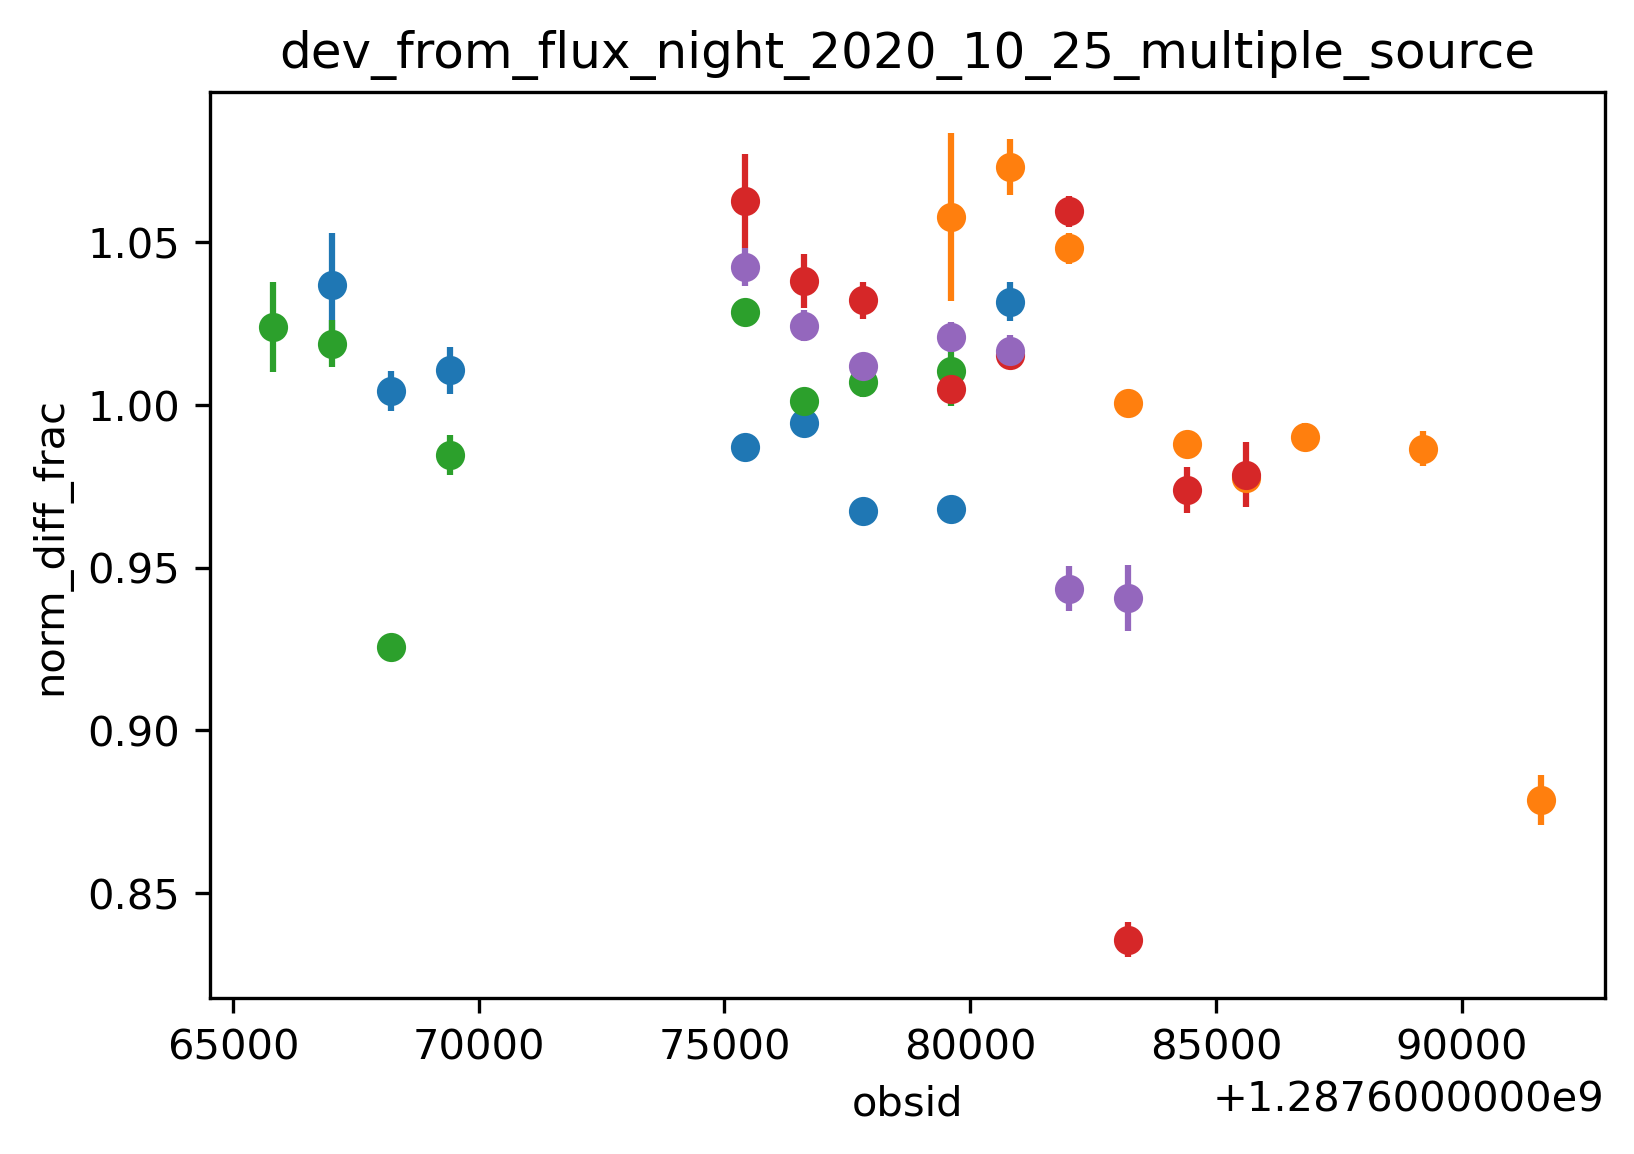

In [19]:
figu=plt.figure(dpi=300)
sources=pd.unique(mega_dataframe_source_based['source'])
amount_of_plots=5#len(sources)
for i in range(amount_of_plots):
    source_index=sources[i]
    mask=mega_dataframe_source_based['source']==source_index
    masked_dataframe=mega_dataframe_source_based[mask]
    masked_dataframe.reset_index(drop=True,inplace=True)
    plt.errorbar(masked_dataframe['obs_id_int'],
        masked_dataframe['norm_diff_frac'],
        yerr=masked_dataframe['error_diff_frac'],
        fmt='o')
    plt.xlabel('obsid')
    plt.ylabel('norm_diff_frac')
titlen=('dev_from_flux_night_'
    +str(masked_dataframe.loc[0,'night'])
    +'_multiple_source')
plt.title(titlen)
# plt.ylim(0.8,1.2)
plt.show()
plt.close()

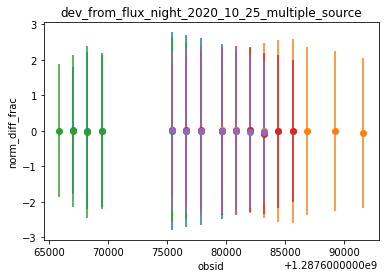

In [20]:
for i in range(amount_of_plots):
    source_index=sources[i]
    mask=mega_dataframe_source_based['source']==source_index
    masked_dataframe=mega_dataframe_source_based[mask]
    masked_dataframe.reset_index(drop=True,inplace=True)
    plt.errorbar(masked_dataframe['obs_id_int'],
        masked_dataframe['log_norm_diff_frac'],
        yerr=masked_dataframe['log_error_diff_frac'],
        fmt='o')
    plt.xlabel('obsid')
    plt.ylabel('norm_diff_frac')
titlen=('dev_from_flux_night_'
    +str(masked_dataframe.loc[0,'night'])
    +'_multiple_source')
plt.title(titlen)
# plt.ylim(-0.5,0.5)
plt.show()
plt.close()

In [21]:
mega_dataframe_source_based['obs_id_int']

0       1287667016
1       1287668216
2       1287669416
3       1287675416
4       1287676616
           ...    
998     1287691616
999     1287691616
1000    1287691616
1001    1287691616
1002    1287692816
Name: obs_id_int, Length: 1003, dtype: int64

In [22]:
sources=pd.unique(mega_dataframe_source_based['source'])
obsids=pd.unique(mega_dataframe_source_based['obs_id_int'])
amount_of_plots=len(obsids)
data_by_obsid=dict()
# obsid_data_norm_diff_frac=pd.DataFrame(mega_dataframe_source_based[mega_dataframe_source_based['obs_id_int']==obsids[0]]['norm_diff_frac'])
for i in range(0,len(obsids)):
    obsid=obsids[i]
    mask=mega_dataframe_source_based['obs_id_int']==obsid
    masked_dataframe=mega_dataframe_source_based[mask]
    masked_dataframe.reset_index(drop=True,inplace=True)
    data_by_obsid[i]=masked_dataframe


In [23]:
data_by_obsid[0]

,island,source,background,local_rms,ra_str,dec_str,ra,err_ra,dec,err_dec,...,norm_diff_frac,log_norm_diff_frac,log_error_diff_frac,error_diff_frac,std_dev_flux,mean_blur_source,mean_diff,data_points,obs_id_int,mean_diff_weight
0,1958,11,0.003084,0.470948,00:37:04.02,-01:09:15.79,9.266762,0.000242,-1.154386,0.000270,...,1.036794,0.015693,-1.797635,0.015935,0.024439,-0.006019,0.106918,8,1287667016,1363.669434
1,2378,1,0.001646,0.152977,00:06:22.61,-00:04:24.89,1.594225,0.000106,-0.073579,0.000129,...,1.018747,0.008067,-2.143970,0.007178,0.030958,-0.006329,0.079684,8,1287667016,888.268616
2,521,160,-0.001615,0.106969,22:37:47.06,-11:45:45.91,339.446075,0.000130,-11.762752,0.000182,...,0.942020,-0.025940,-2.058383,0.008742,0.099686,-0.010265,0.083323,8,1287667016,402.013000
3,406,6,0.003734,0.547502,00:18:51.52,-12:42:37.77,4.714652,0.000504,-12.710490,0.000517,...,1.076420,0.031982,-1.467887,0.034050,0.051041,-0.014947,0.093741,6,1287667016,385.986572
4,530,175,-0.000077,0.147578,23:25:19.82,-12:07:27.86,351.332581,0.000095,-12.124405,0.000117,...,1.027884,0.011944,-2.176745,0.006657,0.030395,-0.019744,0.060214,7,1287667016,343.973419
5,45,144,-0.001893,0.467477,21:23:02.15,-16:28:05.15,320.758942,0.000333,-16.468098,0.000528,...,1.015468,0.006666,-1.601337,0.025042,0.051835,-0.014357,0.111266,6,1287667016,277.551880
6,755,179,-0.002354,0.135183,23:32:25.41,-09:57:56.07,353.105865,0.000182,-9.965576,0.000222,...,1.009646,0.004169,-1.907799,0.012365,0.096186,-0.007707,0.052025,8,1287667016,260.712463
7,1235,2,-0.002687,0.190386,00:08:29.39,-05:58:45.02,2.122445,0.000277,-5.979172,0.000317,...,1.011026,0.004762,-1.738346,0.018266,0.042024,-0.014617,0.085333,8,1287667016,208.092484
8,106,0,0.001608,0.685992,00:03:21.73,-17:27:12.13,0.840537,0.000779,-17.453369,0.000821,...,0.905822,-0.042957,-1.337896,0.045931,0.069506,-0.027876,0.085571,5,1287667016,163.605606
9,316,154,0.001391,0.150641,22:11:24.87,-13:28:12.70,332.853638,0.000301,-13.470193,0.000438,...,0.938462,-0.027583,-1.688621,0.020482,0.132241,0.003273,0.120619,8,1287667016,122.450089


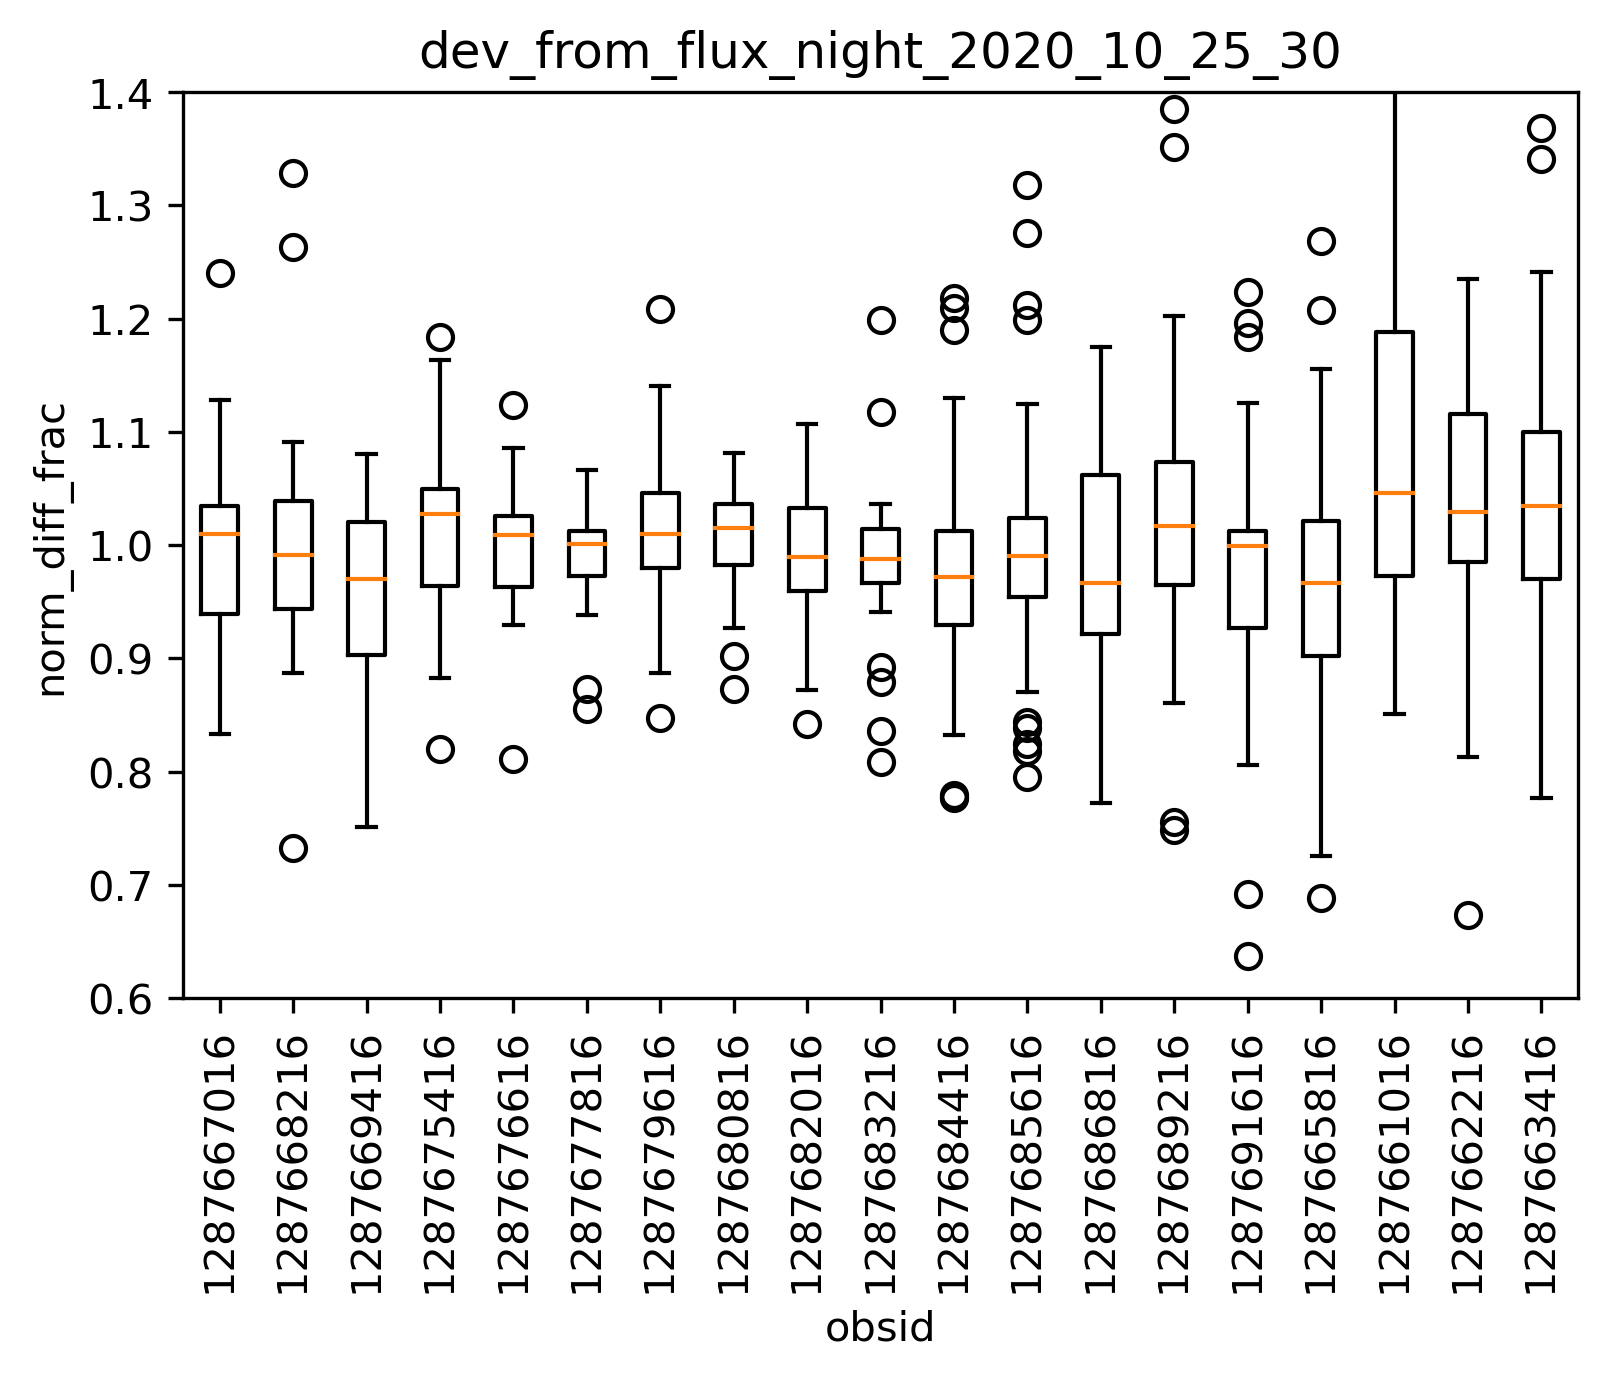

In [24]:
x=30
figu=plt.figure(dpi=300)
plt.boxplot([data_by_obsid[0]['norm_diff_frac'][:x],
            data_by_obsid[1]['norm_diff_frac'][:x],
            data_by_obsid[2]['norm_diff_frac'][:x],
            data_by_obsid[3]['norm_diff_frac'][:x],
            data_by_obsid[4]['norm_diff_frac'][:x],
            data_by_obsid[5]['norm_diff_frac'][:x],
            data_by_obsid[6]['norm_diff_frac'][:x],
            data_by_obsid[7]['norm_diff_frac'][:x],
            data_by_obsid[8]['norm_diff_frac'][:x],
            data_by_obsid[9]['norm_diff_frac'][:x],
            data_by_obsid[10]['norm_diff_frac'],
            data_by_obsid[11]['norm_diff_frac'],
            data_by_obsid[12]['norm_diff_frac'],
            data_by_obsid[13]['norm_diff_frac'],
            data_by_obsid[14]['norm_diff_frac'],
            data_by_obsid[15]['norm_diff_frac'],
            data_by_obsid[16]['norm_diff_frac'],
            data_by_obsid[17]['norm_diff_frac'],
            data_by_obsid[18]['norm_diff_frac']],
            labels=[obsids[0],
            obsids[1],
            obsids[2],
            obsids[3],
            obsids[4],
            obsids[5],
            obsids[6],
            obsids[7],
            obsids[8],
            obsids[9],
            obsids[10],
            obsids[11],
            obsids[12],
            obsids[13],
            obsids[14],
            obsids[15],
            obsids[16],
            obsids[17],
            obsids[18]
            ])
plt.xlabel('obsid')
plt.ylabel('norm_diff_frac')
plt.xticks(rotation='vertical')
titlen=('dev_from_flux_night_'
    +str(masked_dataframe.loc[0,'night'])
    +'_'+str(x))
plt.title(titlen)
plt.ylim(0.6,1.4)
plt.savefig('./'+titlen+'.png')
plt.show()
plt.close()

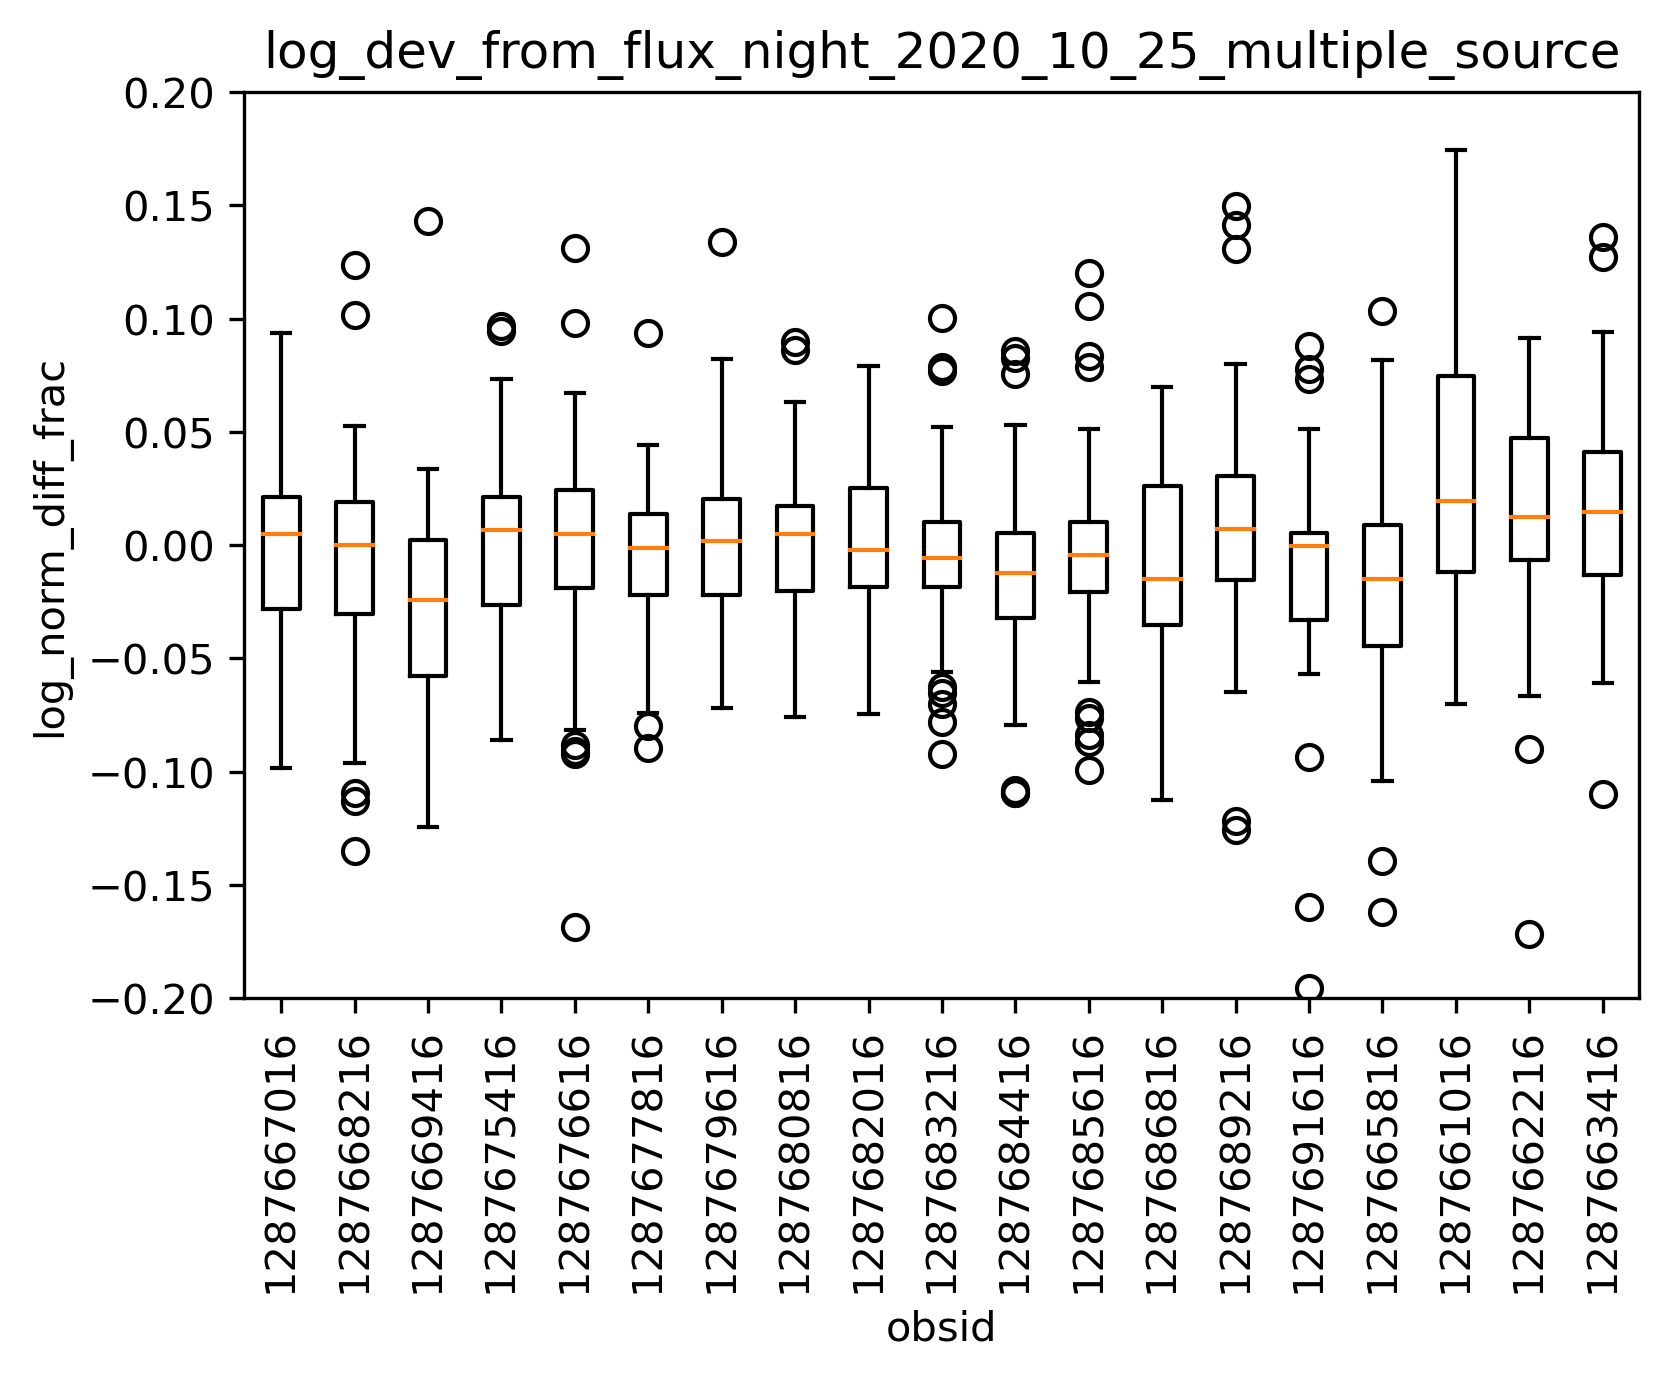

In [25]:
figu=plt.figure(dpi=300)
plt.boxplot([data_by_obsid[0]['log_norm_diff_frac'],
            data_by_obsid[1]['log_norm_diff_frac'],
            data_by_obsid[2]['log_norm_diff_frac'],
            data_by_obsid[3]['log_norm_diff_frac'],
            data_by_obsid[4]['log_norm_diff_frac'],
            data_by_obsid[5]['log_norm_diff_frac'],
            data_by_obsid[6]['log_norm_diff_frac'],
            data_by_obsid[7]['log_norm_diff_frac'],
            data_by_obsid[8]['log_norm_diff_frac'],
            data_by_obsid[9]['log_norm_diff_frac'],
            data_by_obsid[10]['log_norm_diff_frac'],
            data_by_obsid[11]['log_norm_diff_frac'],
            data_by_obsid[12]['log_norm_diff_frac'],
            data_by_obsid[13]['log_norm_diff_frac'],
            data_by_obsid[14]['log_norm_diff_frac'],
            data_by_obsid[15]['log_norm_diff_frac'],
            data_by_obsid[16]['log_norm_diff_frac'],
            data_by_obsid[17]['log_norm_diff_frac'],
            data_by_obsid[18]['log_norm_diff_frac']],
            labels=[obsids[0],
            obsids[1],
            obsids[2],
            obsids[3],
            obsids[4],
            obsids[5],
            obsids[6],
            obsids[7],
            obsids[8],
            obsids[9],
            obsids[10],
            obsids[11],
            obsids[12],
            obsids[13],
            obsids[14],
            obsids[15],
            obsids[16],
            obsids[17],
            obsids[18]
            ])
plt.xlabel('obsid')
plt.ylabel('log_norm_diff_frac')
plt.xticks(rotation='vertical')
titlen=('log_dev_from_flux_night_'
    +str(masked_dataframe.loc[0,'night'])
    +'_multiple_source')
plt.ylim(-0.2,0.2)
plt.title(titlen)
plt.savefig('./'+titlen+'.png')

plt.show()

plt.close()

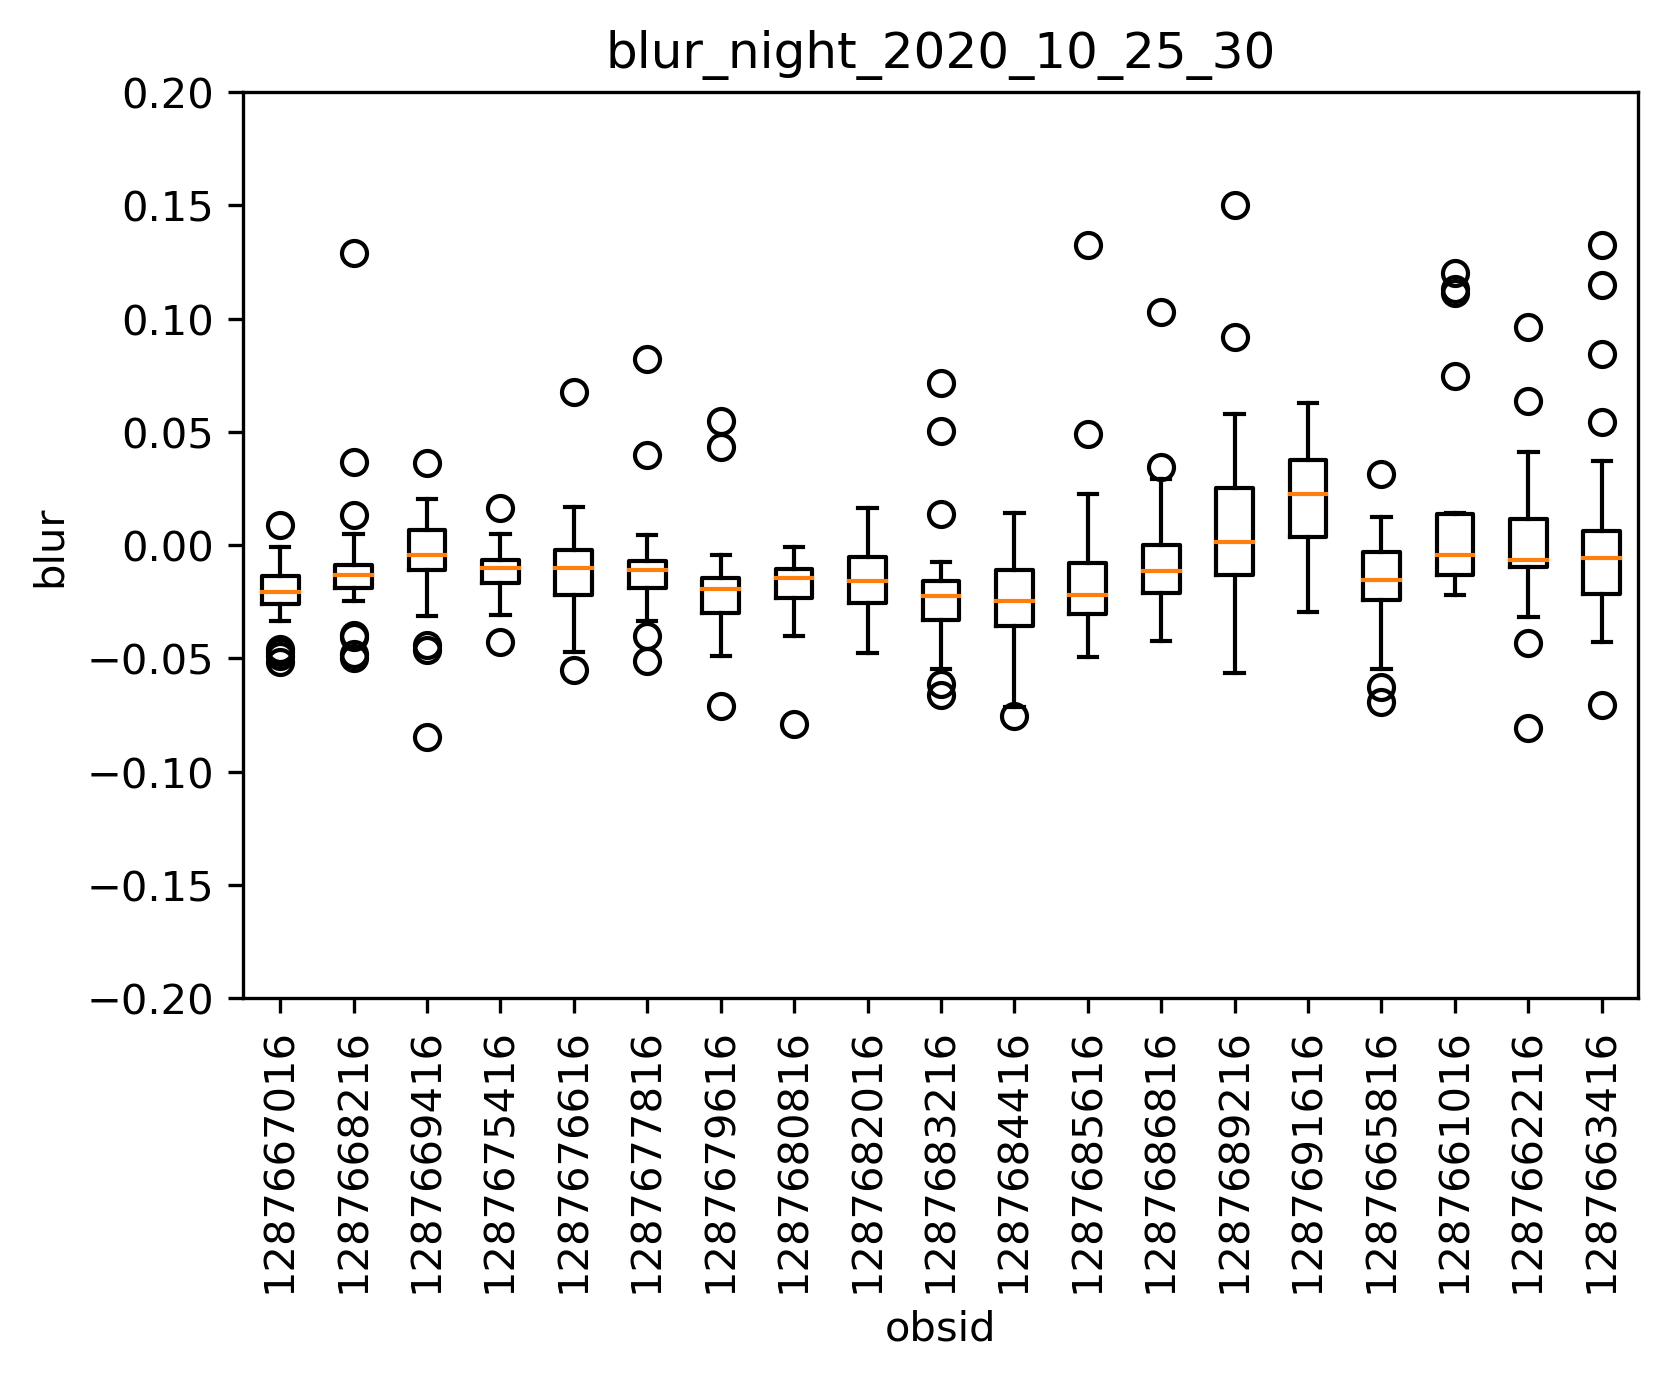

In [26]:
figu=plt.figure(dpi=300)
plt.boxplot([data_by_obsid[0]['blur'][:x],
            data_by_obsid[1]['blur'][:x],
            data_by_obsid[2]['blur'][:x],
            data_by_obsid[3]['blur'][:x],
            data_by_obsid[4]['blur'][:x],
            data_by_obsid[5]['blur'][:x],
            data_by_obsid[6]['blur'][:x],
            data_by_obsid[7]['blur'][:x],
            data_by_obsid[8]['blur'][:x],
            data_by_obsid[9]['blur'][:x],
            data_by_obsid[10]['blur'][:x],
            data_by_obsid[11]['blur'][:x],
            data_by_obsid[12]['blur'][:x],
            data_by_obsid[13]['blur'][:x],
            data_by_obsid[14]['blur'][:x],
            data_by_obsid[15]['blur'][:x],
            data_by_obsid[16]['blur'][:x],
            data_by_obsid[17]['blur'][:x],
            data_by_obsid[18]['blur'][:x]],
            labels=[obsids[0],
            obsids[1],
            obsids[2],
            obsids[3],
            obsids[4],
            obsids[5],
            obsids[6],
            obsids[7],
            obsids[8],
            obsids[9],
            obsids[10],
            obsids[11],
            obsids[12],
            obsids[13],
            obsids[14],
            obsids[15],
            obsids[16],
            obsids[17],
            obsids[18]
            ])
plt.xlabel('obsid')
plt.ylabel('blur')
plt.xticks(rotation='vertical')
titlen=('blur_night_'
    +str(masked_dataframe.loc[0,'night'])
    +'_'+str(x))
plt.title(titlen)
plt.ylim(-0.2,0.2)
plt.savefig('./'+titlen+'.png')
plt.show()
plt.close()

In [27]:
night_info_dict={'night':mega_dataframe_source_based['night'][0],
                'min_obsid':np.nanmin(mega_dataframe_source_based['obs_id']),
                'max_obsid':np.nanmax(mega_dataframe_source_based['obs_id']),
                'mean_blur':np.nanmean(mega_dataframe_source_based['blur']),
                'min_blur':np.nanmin(mega_dataframe_source_based['blur']),
                'max_blur':np.nanmax(mega_dataframe_source_based['blur']),
                'mean_rms':np.nanmean(mega_dataframe_source_based['local_rms']),
                'mean_sep':np.nanmean(mega_dataframe_source_based['sep_NVSS_GLEAM-X']),
                'max_sep':np.nanmax(mega_dataframe_source_based['sep_NVSS_GLEAM-X']),
                'std_sep':np.nanstd(mega_dataframe_source_based['sep_NVSS_GLEAM-X']),
                'min_frac_flux':np.nanmin(mega_dataframe_source_based['norm_diff_frac']),
                'mean_frac_flux':np.nanmean(mega_dataframe_source_based['norm_diff_frac']),
                'max_frac_flux':np.nanmax(mega_dataframe_source_based['norm_diff_frac']),
                'std_dev_normflux':np.nanmean(mega_dataframe_source_based['std_dev_flux']),
                }
night_info_dataframe=pd.DataFrame(night_info_dict,index=[0])
night_info_dataframe

,night,min_obsid,max_obsid,mean_blur,min_blur,max_blur,mean_rms,mean_sep,max_sep,std_sep,min_frac_flux,mean_frac_flux,max_frac_flux,std_dev_normflux
0,2020_10_25,1287661016,1287692816,-0.002234,-0.115211,0.368602,0.215595,0.148907,0.499609,0.110303,0.637585,1.0,1.779729,0.094639
